In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import random
import numpy as np
from itertools import product
import pandas as pd
import glob
import os
import zipfile
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix

!pip install seaborn

### Extracting images

In [ ]:
zip_path = 'lfwa.zip'

extract_to = 'lfwa/'

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Files extracted successfully!")

In [ ]:
# load the train and test samples
with open(f'train.txt', 'r') as f:
    train = list(csv.reader(f, delimiter='\t'))[1:]
with open(f'test.txt', 'r') as f:
    test= list(csv.reader(f, delimiter='\t'))[1:]

### Printing examples for changes in images

Cropped Images


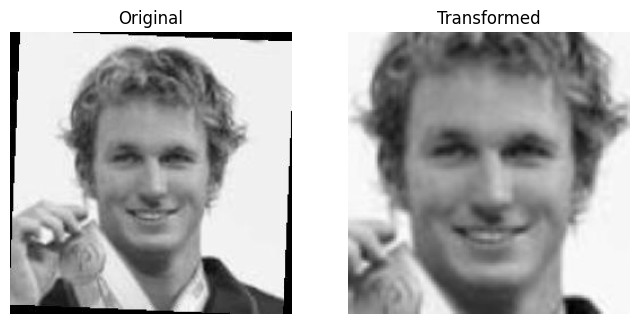

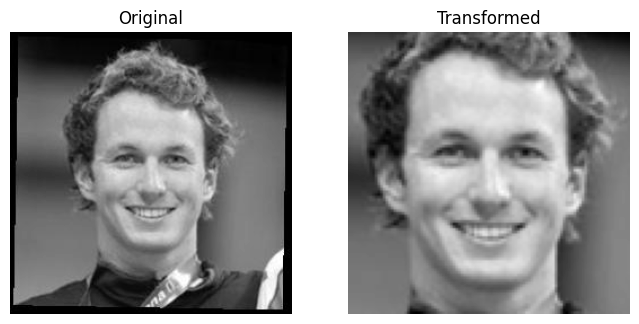

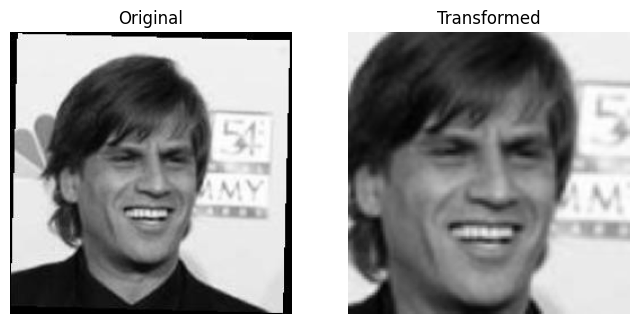

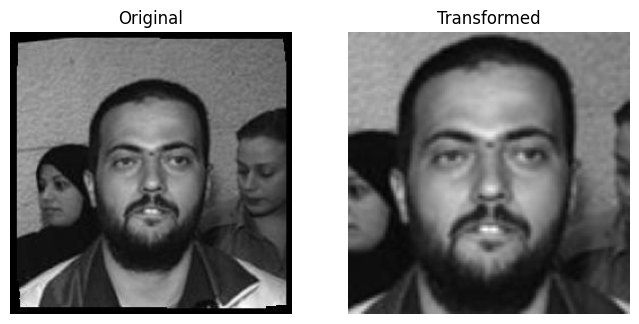

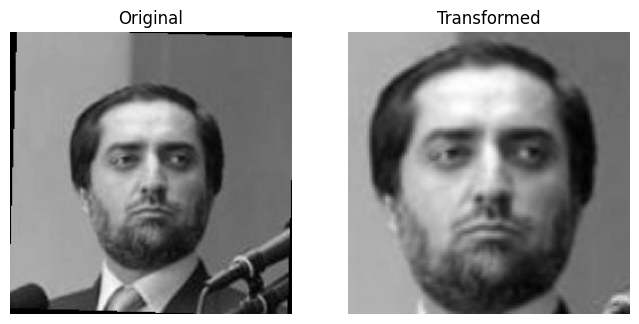

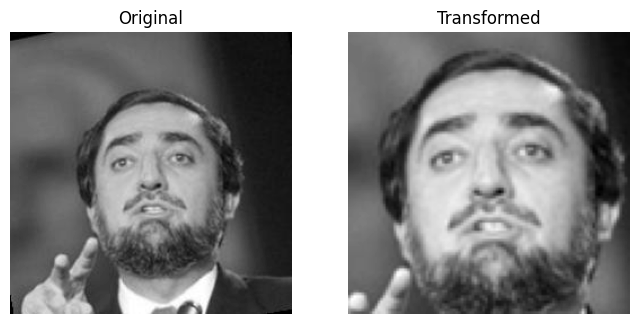

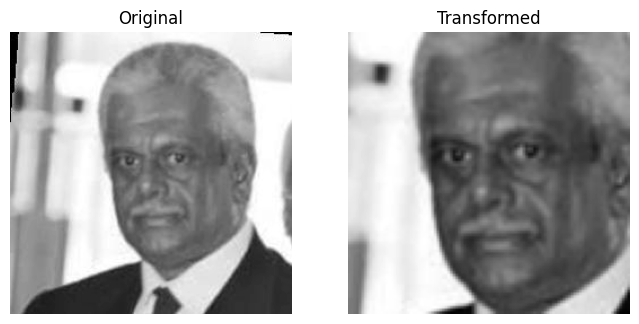

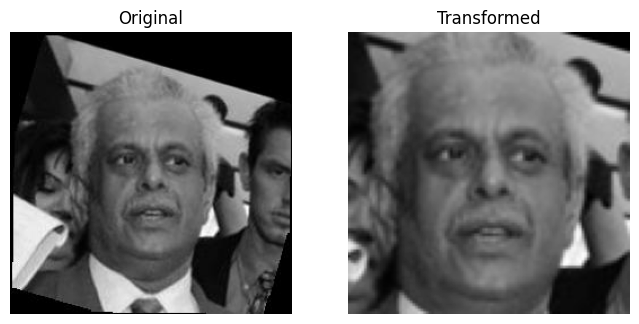

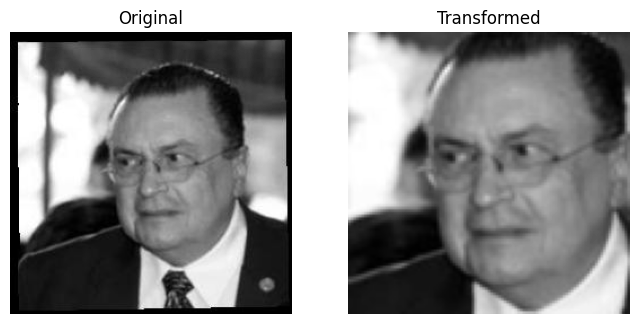

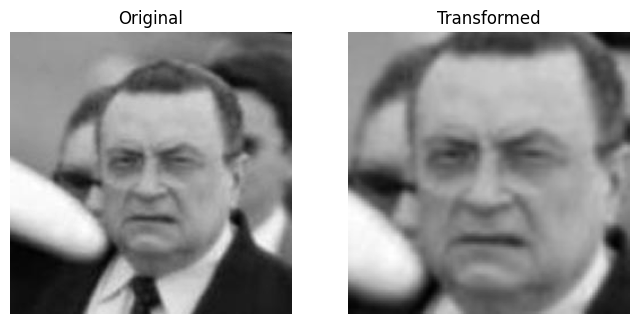

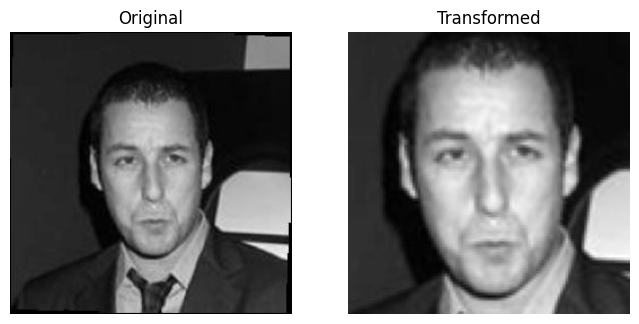

----------------------------------------------------------------------------------------------------
Augumantation Images


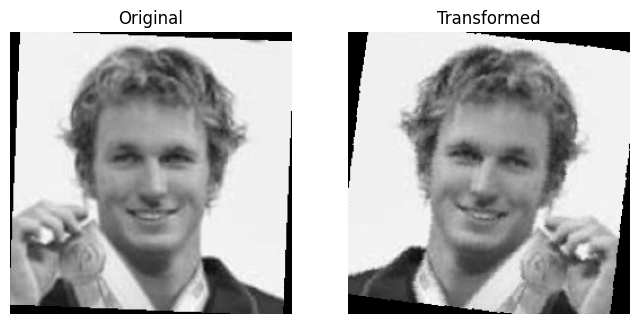

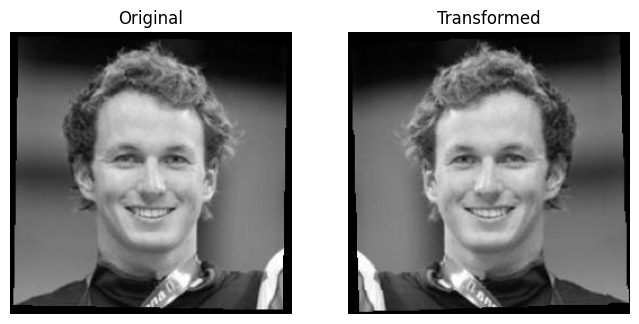

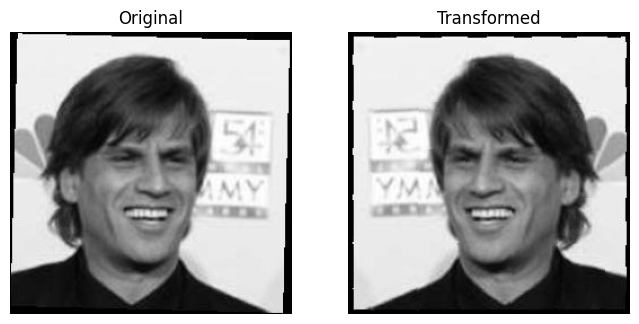

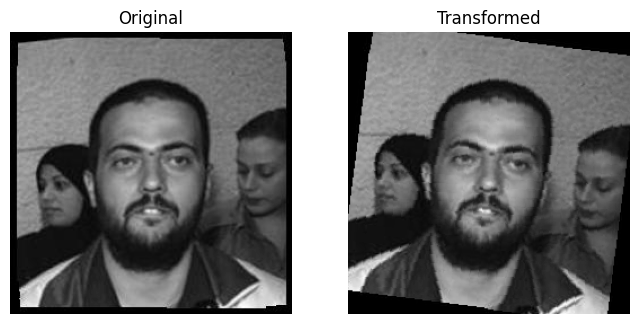

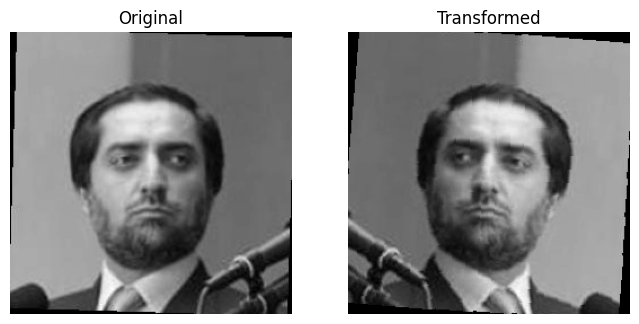

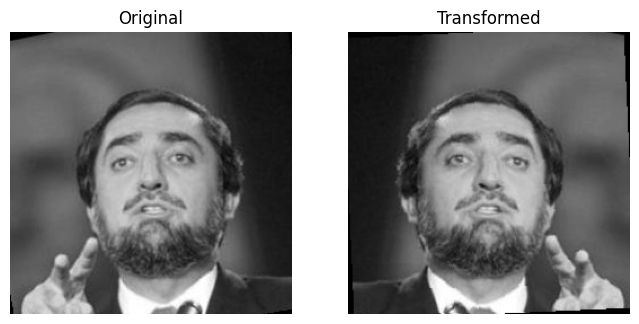

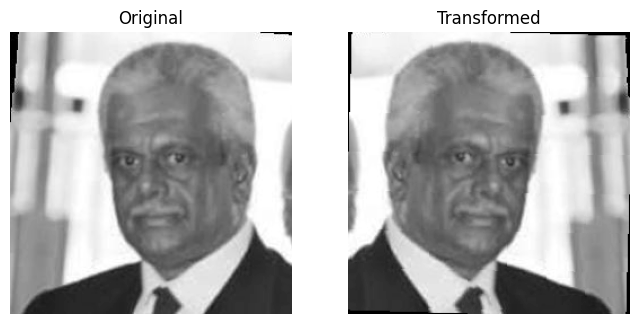

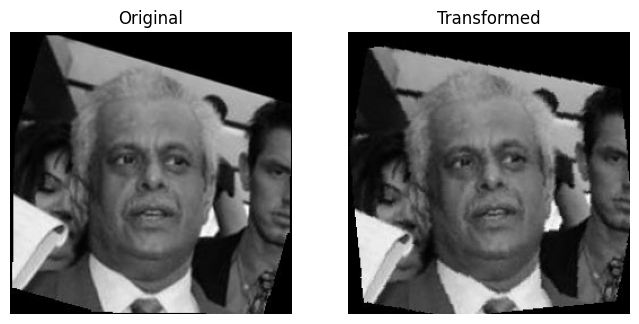

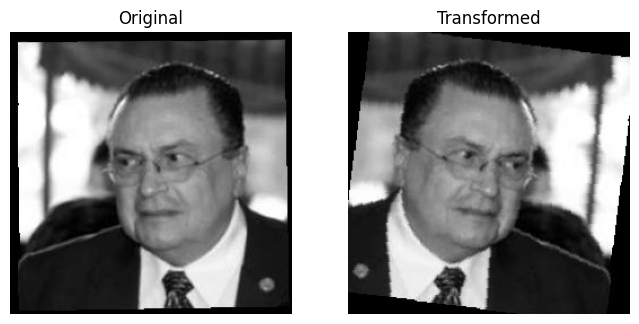

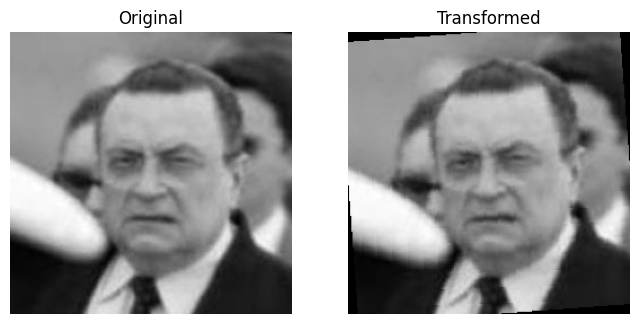

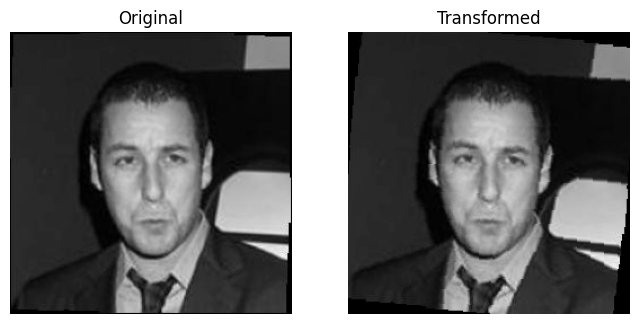

In [ ]:
# Define a custom transform to crop border pixels and resize
class CropResizeTransform:
    def __init__(self, border_pixels, new_size):
        self.border_pixels = border_pixels
        self.new_size = new_size
    def __call__(self, image):
        width, height = image.size
        left, top, right, bottom = self.border_pixels, self.border_pixels, width - self.border_pixels, height - self.border_pixels
        cropped_image = image.crop((left, top, right, bottom))
        resized_image = cropped_image.resize(self.new_size)
        return resized_image

border_pixels = 40  # Number of pixels to crop from each side
new_size = (105, 105)  # New size after resizing
transform = transforms.Compose([CropResizeTransform(border_pixels, new_size), transforms.Grayscale(num_output_channels=1)])

# Cropped
print("Cropped Images")

for i, m in enumerate(train):
    image_path = f"./lfwa/lfw2/lfw2/{m[0]}/{m[0]}_000{m[1]}.jpg"
    try:
        im = Image.open(image_path)
    except:
        continue
    im_transformed = transform(im)

    # Display original and transformed images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(im_transformed, cmap='gray')
    plt.title("Transformed")
    plt.axis('off')

    plt.show()

    if i == 10:
        break

# ----------------------------------------------------------------------------------------------------------------
print("-" * 100)

# Augumantation


transform_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
            transforms.RandomRotation(degrees=10)])  # Randomly rotate the image by up to 10 degrees

print("Augumantation Images")


for i, m in enumerate(train):
    image_path = f"./lfwa/lfw2/lfw2/{m[0]}/{m[0]}_000{m[1]}.jpg"
    try:
        im = Image.open(image_path)
    except:
        continue
    im_transformed = transform_aug(im)

    # Display original and transformed images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(im_transformed, cmap='gray')
    plt.title("Transformed")
    plt.axis('off')

    plt.show()

    if i == 10:
        break

### Dataset Class

In [ ]:
# class for custom cropping
class CustomCropTransform:
    def __init__(self, border_pixels):
        self.border_pixels = border_pixels

    def __call__(self, image):
        width, height = image.size
        left, top, right, bottom = self.border_pixels, self.border_pixels, width - self.border_pixels, height - self.border_pixels
        cropped_image = image.crop((left, top, right, bottom))
        return cropped_image

# class for images dataset
class ImageLoader(Dataset):
    def __init__(self, text_data, type_of_dataset):
        self.text_data = text_data

        if type_of_dataset == 'train':
            self.transform = transforms.Compose([
                CustomCropTransform(25),  # Apply custom crop transform
                transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
                transforms.RandomRotation(degrees=10),  # Randomly rotate the image by up to 10 degrees
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
                transforms.Resize((105, 105)),  # Resize to 105x105 pixels
                transforms.ToTensor(),  # Convert to a PyTorch tensor
                transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
            ])
        else:
            self.transform = transforms.Compose([
                CustomCropTransform(25),  # Apply custom crop transform
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
                transforms.Resize((105, 105)),  # Resize to 105x105 pixels
                transforms.ToTensor(),  # Convert to a PyTorch tensor
                transforms.Normalize((0.5,), (0.5,))])  # Normalize pixel values

    def __len__(self):
        return len(self.text_data)


    def loadAndPreprocessImage(self, name, number):
        number = '{:04d}'.format(int(number))
        image = Image.open(f"./lfwa/lfw2/lfw2/{name}/{name}_{number}.jpg")

        return self.transform(image)


    def __getitem__(self, idx):
        data = self.text_data[idx]

        if len(data) == 3:
            person1, image_num_1, image_num_2 = data # same person
            person2 = person1
            label = 1.0
        else:
            person1, image_num_1, person2, image_num_2 = data #not same person
            label = 0.0

        image1 = self.loadAndPreprocessImage(person1, image_num_1)
        image2 = self.loadAndPreprocessImage(person2, image_num_2)

        return image1, image2, torch.tensor(label)

In [ ]:
# Calculate the number of samples with the same and different persons in each dataset
def count_samples(data_rows):
    same_person = sum([1 for row in data_rows if len(row) == 3])
    different_person = len(data_rows) - same_person
    return same_person, different_person


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# split to train ans test
train, val = train_test_split(train, test_size=0.1, random_state=42)

# Define the dataset splits
train_same, train_not = count_samples(train)
val_same, val_not = count_samples(val)
test_same, test_not = count_samples(test)

print("Train set:")
print("Number of samples of the same person:", train_same)
print("Number of samples of different persons:", train_not, "\n")

print("Validation set:")
print("Number of samples of the same person:", val_same)
print("Number of samples of different persons:", val_not, "\n")

print("Test set:")
print("Number of samples of the same person:", test_same)
print("Number of samples of different persons:", test_not)


Train set:
Number of samples of the same person: 979
Number of samples of different persons: 1001 

Validation set:
Number of samples of the same person: 121
Number of samples of different persons: 99 

Test set:
Number of samples of the same person: 500
Number of samples of different persons: 500


In [ ]:
# define datasets for train, validation and test
train_dataset = ImageLoader(train, 'train')
val_dataset = ImageLoader(val, 'validation')
test_dataset = ImageLoader(test, 'test')

## SiameseNetwork

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, use_batch_norm=False ,use_dropout=False,dropout_rate=0.0 ):
        super(SiameseNetwork, self).__init__()
        # convolution layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=10, stride=1, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0)

        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fc2 = nn.Linear(4096, 1)

        # batch normalization layers
        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        self.bn2 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        self.bn4 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity()
        # dropout layers
        self.dropout1 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()
        self.dropout2 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()
        self.dropout3 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()
        self.dropout4 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()

        self.fc_dropout = nn.Dropout(dropout_rate) if use_dropout else nn.Identity()

        self.alpha = nn.Parameter(torch.randn(4096))

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.normal_(m.bias, mean=0.5, std=0.01)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.2)
                nn.init.normal_(m.bias, mean=0.5, std=0.01)

    def forward_one(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(x.size(0), -1)
        x = self.fc_dropout(self.fc1(x))

        return torch.sigmoid(x)

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)

        distance = torch.abs(output1 - output2)

        weighted_distance = self.alpha * distance

        similarity_score = torch.sigmoid(self.fc2(weighted_distance))

        return similarity_score

## Function Decleration

In [ ]:
# given an array on model outputs and labels calculates the accuracy
def calculate_accuracy(outputs , labels):
  preds = outputs > 0.5
  correct = (preds == labels).float()
  accuracy = correct.sum() / len(correct)
  return accuracy


# calculates the validation error given a validation datset and a model
def calculate_validation_error(model, dataloader):
    model.eval()
    validation_error = 0.0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            similarity_score = model(img0, img1)
            loss = criterion(similarity_score, label.unsqueeze(1))
            validation_error += loss.item()

    validation_error /= len(dataloader)
    return validation_error

# evaluates the model to use during the training given the model and the validation dataset
def evaluate_model(model,dataloader):
    model.eval()
    f_accuracy = 0.0
    with torch.no_grad():
      for i, data in enumerate(dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        similarity_score = model(img0, img1)

        data_accuracy = calculate_accuracy(similarity_score, label.unsqueeze(1))
        f_accuracy += data_accuracy

    f_accuracy /= len(dataloader)
    return f_accuracy


### Plot Graphs

In [ ]:
import matplotlib.pyplot as plt

# saves the plot of training loss and validation error
def plot_losses(train_losses, validation_errors, directory_to_save):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_errors, label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Error')
    plt.legend()
    plt.title('Training Loss and Validation Error over Epochs')
    plt.savefig(os.path.join(experiment_dir, 'loss_plot.png'))

# saves the plot of convergence time during the training
def plot_convergence_times(epoch_times, directory_to_save):
    plt.figure(figsize=(10,5))
    plt.plot(epoch_times, label='Epoch Time')
    plt.xlabel('Epochs')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.title('Convergence Time per Epoch')
    plt.savefig(os.path.join(experiment_dir, 'convergence_plot.png'))
=


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Hyperparameters Tuning

In [ ]:
# all the hyperparameter options
lr_options = [1e-4, 1e-3, 1e-2, 1e-1]
momentum_ends_options = [0.8, 0.85, 0.9, 0.95]
weight_decays_options = [0.0, 0.01, 0.1]
use_batchnorm = [True,False]
use_dropout = [True,False]
batch_size = [16,32]

# Generate combinations of hyperparameters
hyperparameter_combinations = list(product(
    lr_options, momentum_ends_options, weight_decays_options, use_batchnorm, use_dropout, batch_size
))

print(f'The amount of hyperparameters combinations is: {len(hyperparameter_combinations)}.')

experiment_dir = 'experiments'
os.makedirs(experiment_dir, exist_ok=True)


# Perform manual hyperparameter search
for hyperparameters in hyperparameter_combinations:
    lr, momentum_end, weight_decay, use_batchnorm, use_dropout, batch_size = hyperparameters

    results_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Convergence Time', 'Test Accuracy'])

    experiment_subdir = f"{num_epochs}_{lr}_{weight_decay}_{momentum_end}_{use_batchnorm}_{use_dropout}_{batch_size}"
    experiment_dir = os.path.join('experiments', experiment_subdir)
    os.makedirs(experiment_dir, exist_ok=True)

    model = SiameseNetwork(use_batchnorm, use_dropout, 0.5).cuda()

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.99)
    criterion = nn.BCELoss()

    epochs_without_improvement = 0
    max_epochs_without_improvement = 20
    num_epochs = 100  # Reduced for hyperparameter search

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
    validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

    best_validation_loss = float('inf')
    train_losses = []
    validation_losses = []
    epoch_times = []
    best_epoch = -1


    for epoch in range(num_epochs):
      start_time = time.time()

      model.train()
      running_loss = 0.0
      for i, data in enumerate(train_dataloader, 0):
          img0, img1, label = data
          img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

          optimizer.zero_grad()
          similarity_score = model(img0, img1)
          loss = criterion(similarity_score, label.unsqueeze(1))

          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      train_loss = running_loss / len(train_dataloader)
      train_losses.append(train_loss)

      # Update momentum
      for j, param_group in enumerate(optimizer.param_groups):
          new_momentum = 0.5 + (momentum_end - 0.5) * (epoch / num_epochs)
          param_group['momentum'] = new_momentum


      # Calculate validation error
      validation_loss = calculate_validation_error(model, validation_dataloader)
      print(f"Epoch {epoch}, Validation Loss: {validation_loss}")
      validation_losses.append(validation_loss)

      epoch_time = time.time() - start_time
      epoch_times.append(epoch_time)

      results_df = pd.concat([results_df, pd.DataFrame({'Epoch': [epoch + 1], 'Train Loss': [train_loss], 'Train Accuracy': None , 'Validation Loss': [validation_loss], 'Validation Accuracy': None, 'Convergence Time': [epoch_time], 'Test Accuracy': None})], ignore_index=True)

      # stoping critirion
      if validation_loss < best_validation_loss:
          best_validation_loss = validation_loss
          best_epoch = epoch
          best_model_path = os.path.join(experiment_dir, 'best_model.pt')
          torch.save(model.state_dict(), best_model_path)
          epochs_without_improvement = 0
      else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= max_epochs_without_improvement:
              break

      #update learning rate
      scheduler.step()

    # load the best model for the accuracy calculation
    best_model_path = os.path.join(experiment_dir, 'best_model.pt')
    model.load_state_dict(torch.load(best_model_path))

    train_accuracy = evaluate_model(model,train_dataloader)
    validation_accuracy = evaluate_model(model,validation_dataloader)
    test_accuracy = evaluate_model(model,test_dataloader)

    results_df = pd.concat([results_df, pd.DataFrame({'Epoch': ['Accuracy'], 'Train Loss': None, 'Train Accuracy': train_accuracy.item() , 'Validation Loss': None, 'Validation Accuracy': validation_accuracy.item(), 'Convergence Time': None, 'Test Accuracy': test_accuracy.item()})], ignore_index=True)

    results_csv = os.path.join(experiment_dir, 'results.csv')

    if os.path.exists(results_csv):
        os.remove(results_csv)

    results_df.to_csv(results_csv, index=False)
    print('Total Convergence Time', results_df['Convergence Time'].sum())

    plot_graph(train_losses, validation_errors, experiment_dir)
    plot_convergence_times(epoch_times, experiment_dir)

    print(f'Done with parameters: {hyperparameters}')


### Finding the best trained model and retraining with 200 epochs

In [ ]:
import os
import pandas as pd

def get_top_experiments(base_directory, top_n=10):
    # Dictionary to hold the subdirectory and its corresponding max test accuracy
    accuracy_records = {}

    # Iterate over all directories in the base directory
    for subdir in os.listdir(base_directory):
        results_path = os.path.join(base_directory, subdir, 'results.csv')
        if os.path.exists(results_path):
            try:
                results_df = pd.read_csv(results_path)
                max_test_accuracy = results_df['Test Accuracy'].dropna().max()
                accuracy_records[subdir] = (max_test_accuracy, results_df)
            except Exception as e:
                print(f"Error reading {results_path}: {e}")

    # Sort directories by test accuracy
    sorted_records = sorted(accuracy_records.items(), key=lambda x: x[1][0], reverse=True)

    # Return top N directories with DataFrame
    return sorted_records[:top_n]

# parse the subdirectory name to extract hyperparameters
def extract_parameters(top_experiments, base_directory):
    parameter_lists = []
    for experiment, _ in top_experiments:
        parameters_str = experiment.split('_')
        if len(parameters_str) == 6:
            lr = float(parameters_str[0])
            weight_decay = float(parameters_str[1])
            momentum_end = float(parameters_str[2])
            use_batchnorm = parameters_str[3] == 'True'
            use_dropout = parameters_str[4] == 'True'
            batch_size = int(parameters_str[5])
            parameter_lists.append([lr, momentum_end, weight_decay, use_batchnorm, use_dropout, batch_size])
        else:
            print(f"Unexpected parameter format in directory name: {experiment}")
    return parameter_lists

father_experiment_dir = 'experiments1'
top_experiments = get_top_experiments(father_experiment_dir)

top_parameters = extract_parameters(top_experiments, father_experiment_dir)

print(top_parameters)


[[0.01, 0.9, 0.01, True, False, 32], [0.01, 0.95, 0.01, True, False, 32], [0.01, 0.8, 0.01, True, False, 32], [0.01, 0.9, 0.01, True, False, 16], [0.01, 0.85, 0.01, True, False, 16], [0.01, 0.8, 0.01, True, False, 16], [0.01, 0.85, 0.01, True, False, 32], [0.01, 0.95, 0.01, True, False, 16], [0.01, 0.9, 0.01, False, False, 16], [0.01, 0.8, 0.01, False, False, 16]]


In [ ]:
father_experiment_dir = 'best_results'
os.makedirs(father_experiment_dir, exist_ok=True)

# retrain all the best models with 200 epochs
for hyperparameters in top_parameters:
    print(hyperparameters)
    lr, momentum_end, weight_decay, use_batchnorm, use_dropout, batch_size = hyperparameters

    results_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Convergence Time', 'Test Accuracy'])

    experiment_subdir = f"{lr}_{weight_decay}_{momentum_end}_{use_batchnorm}_{use_dropout}_{batch_size}"
    experiment_dir = os.path.join(father_experiment_dir, experiment_subdir)

    if os.path.exists(experiment_dir):
      print(f"Skipping completed combination: {experiment_subdir}")
      continue

    os.makedirs(experiment_dir, exist_ok=True)

    model = SiameseNetwork(use_batchnorm, use_dropout, 0.5).cuda()

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.99)
    criterion = nn.BCELoss()

    epochs_without_improvement = 0
    max_epochs_without_improvement = 20
    num_epochs = 200

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
    validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

    best_validation_loss = float('inf')
    train_losses = []
    validation_losses = []
    epoch_times = []
    best_epoch = -1


    for epoch in range(num_epochs):
      start_time = time.time()

      model.train()
      running_loss = 0.0
      for i, data in enumerate(train_dataloader, 0):
          img0, img1, label = data
          img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

          optimizer.zero_grad()
          similarity_score = model(img0, img1)
          loss = criterion(similarity_score, label.unsqueeze(1))

          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      train_loss = running_loss / len(train_dataloader)
      train_losses.append(train_loss)

      for j, param_group in enumerate(optimizer.param_groups):
          new_momentum = 0.5 + (momentum_end - 0.5) * (epoch / num_epochs)
          param_group['momentum'] = new_momentum


      validation_loss = calculate_validation_error(model, validation_dataloader)
      validation_losses.append(validation_loss)

      epoch_time = time.time() - start_time
      epoch_times.append(epoch_time)

      results_df = pd.concat([results_df, pd.DataFrame({'Epoch': [epoch + 1], 'Train Loss': [train_loss], 'Train Accuracy': None , 'Validation Loss': [validation_loss], 'Validation Accuracy': None, 'Convergence Time': [epoch_time], 'Test Accuracy': None})], ignore_index=True)

      if validation_loss < best_validation_loss:
          best_validation_loss = validation_loss
          best_epoch = epoch
          best_model_path = os.path.join(experiment_dir, 'best_model.pt')
          torch.save(model.state_dict(), best_model_path)
          epochs_without_improvement = 0
      else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= max_epochs_without_improvement:
              break

      scheduler.step()

    best_model_path = os.path.join(experiment_dir, 'best_model.pt')
    model.load_state_dict(torch.load(best_model_path))

    train_accuracy = evaluate_model(model,train_dataloader)
    validation_accuracy = evaluate_model(model,validation_dataloader)
    test_accuracy = evaluate_model(model,test_dataloader)

    results_df = pd.concat([results_df, pd.DataFrame({'Epoch': ['Accuracy'], 'Train Loss': None, 'Train Accuracy': train_accuracy.item() , 'Validation Loss': None, 'Validation Accuracy': validation_accuracy.item(), 'Convergence Time': None, 'Test Accuracy': test_accuracy.item()})], ignore_index=True)

    results_csv = os.path.join(experiment_dir, 'results.csv')

    if os.path.exists(results_csv):
        os.remove(results_csv)

    results_df.to_csv(results_csv, index=False)

    plot_losses(train_losses, validation_losses, experiment_dir)
    plot_convergence_times(epoch_times, experiment_dir)

    print(f'Done with parameters: {hyperparameters}')

Subdirectory: 0.01_0.01_0.95_True_False_16
Test Accuracy: 0.8115079998970032
Number of Epochs: 99
Train Accuracy: 0.9754704236984252
Validation Accuracy: 0.8333333730697632
Total Convergence Time: 262.14871621131897 seconds


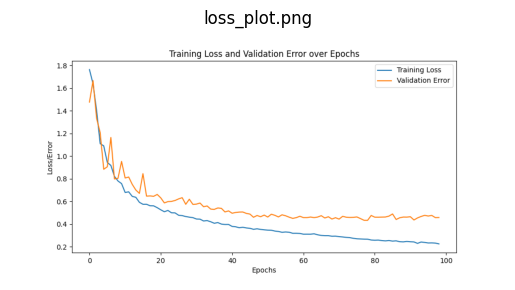

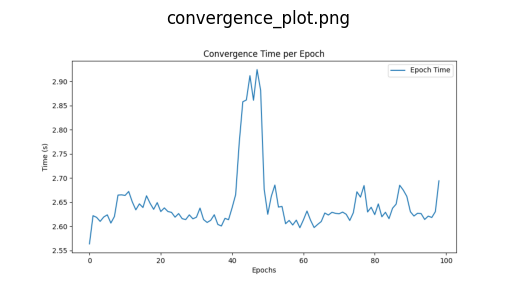

Subdirectory: 0.01_0.01_0.8_True_False_32
Test Accuracy: 0.8037109375
Number of Epochs: 117
Train Accuracy: 0.9933755397796632
Validation Accuracy: 0.8176020383834839
Total Convergence Time: 287.7922875881195 seconds


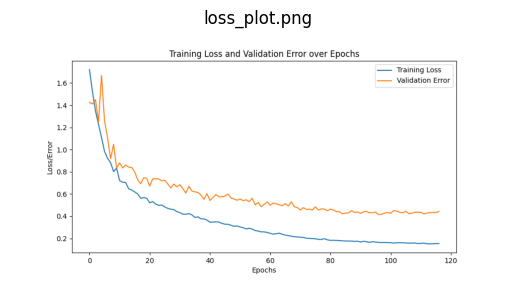

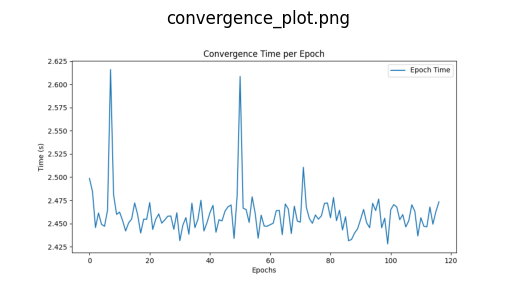

Subdirectory: 0.01_0.01_0.8_True_False_16
Test Accuracy: 0.7946429252624512
Number of Epochs: 91
Train Accuracy: 0.9579972624778748
Validation Accuracy: 0.7946428656578064
Total Convergence Time: 236.2482533454895 seconds


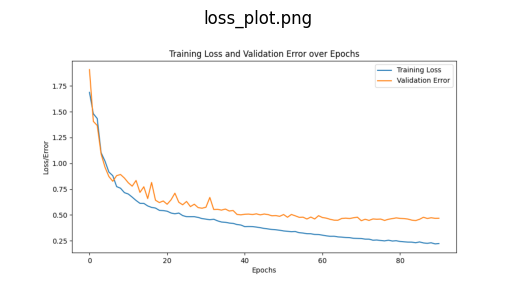

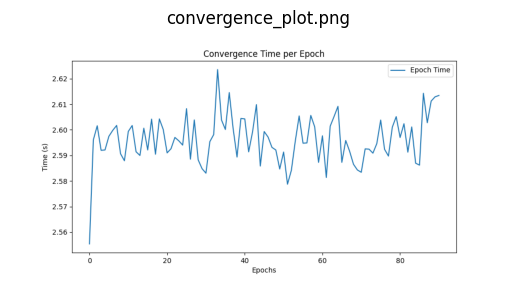

Subdirectory: 0.01_0.01_0.9_True_False_32
Test Accuracy: 0.7890625
Number of Epochs: 124
Train Accuracy: 0.9928715229034424
Validation Accuracy: 0.802295982837677
Total Convergence Time: 305.3640367984772 seconds


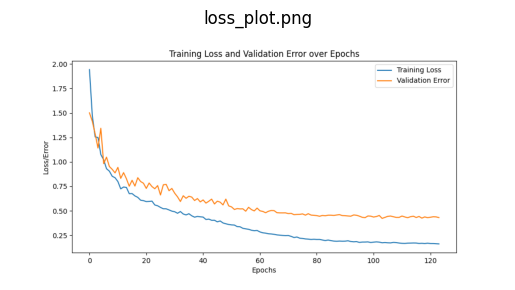

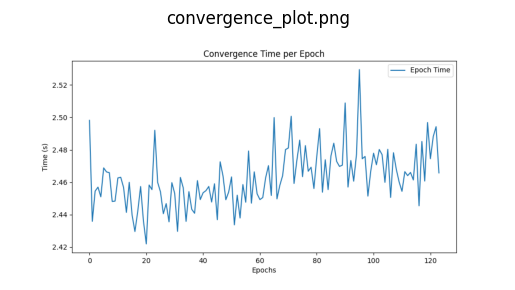

Subdirectory: 0.01_0.01_0.85_True_False_32
Test Accuracy: 0.787109375
Number of Epochs: 139
Train Accuracy: 0.994455635547638
Validation Accuracy: 0.8411990404129028
Total Convergence Time: 343.45508551597595 seconds


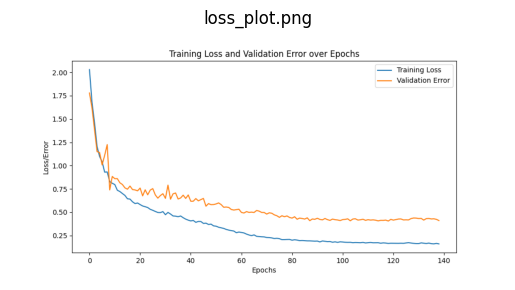

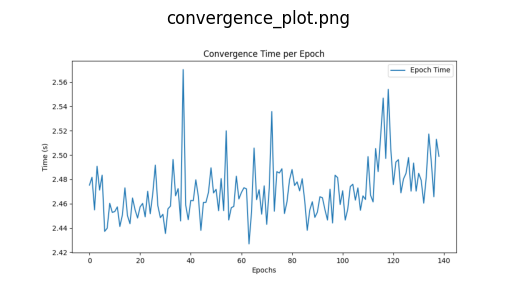

Subdirectory: 0.01_0.01_0.85_True_False_16
Test Accuracy: 0.7817460894584656
Number of Epochs: 100
Train Accuracy: 0.971774160861969
Validation Accuracy: 0.797619104385376
Total Convergence Time: 259.25093126296997 seconds


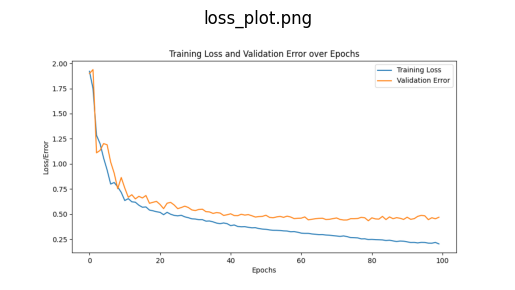

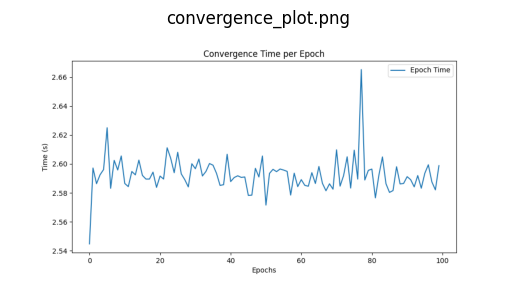

Subdirectory: 0.01_0.01_0.9_True_False_16
Test Accuracy: 0.780754029750824
Number of Epochs: 149
Train Accuracy: 0.984375
Validation Accuracy: 0.805059552192688
Total Convergence Time: 387.0459973812103 seconds


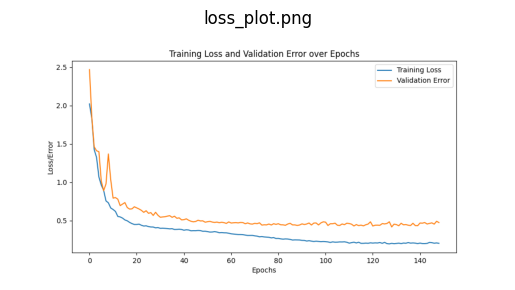

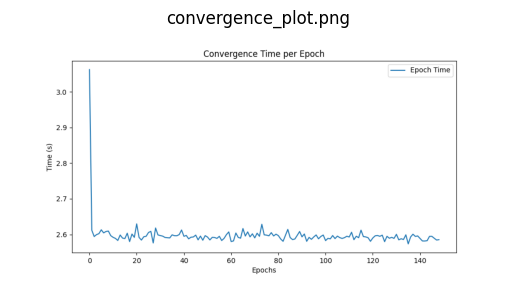

Subdirectory: 0.01_0.01_0.8_False_False_16
Test Accuracy: 0.7797619700431824
Number of Epochs: 84
Train Accuracy: 0.9181787371635436
Validation Accuracy: 0.7946428656578064
Total Convergence Time: 213.2181432247162 seconds


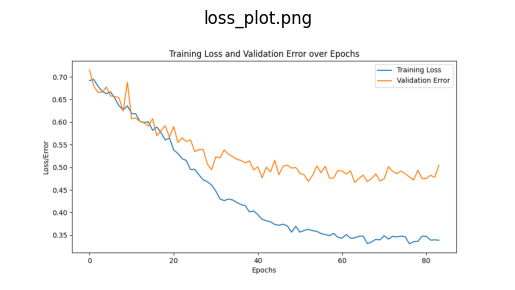

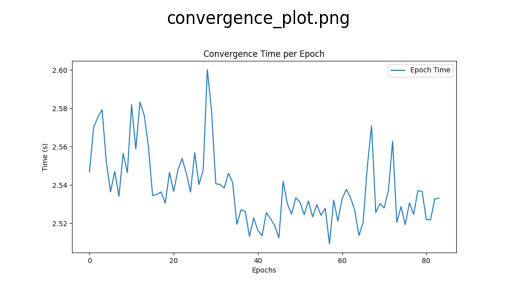

Subdirectory: 0.01_0.01_0.95_True_False_32
Test Accuracy: 0.775390625
Number of Epochs: 109
Train Accuracy: 0.9913594126701356
Validation Accuracy: 0.8316327333450317
Total Convergence Time: 272.17106080055237 seconds


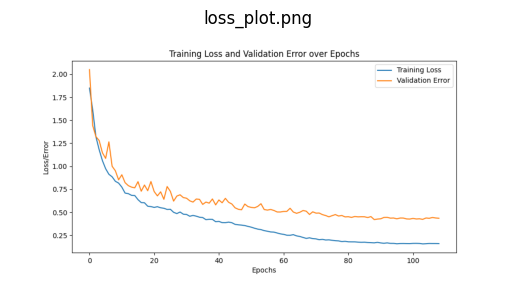

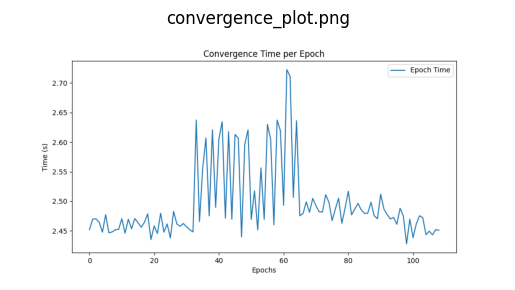

Subdirectory: 0.01_0.01_0.9_False_False_16
Test Accuracy: 0.740079402923584
Number of Epochs: 49
Train Accuracy: 0.7694892287254333
Validation Accuracy: 0.7559524178504944
Total Convergence Time: 125.99350643157959 seconds


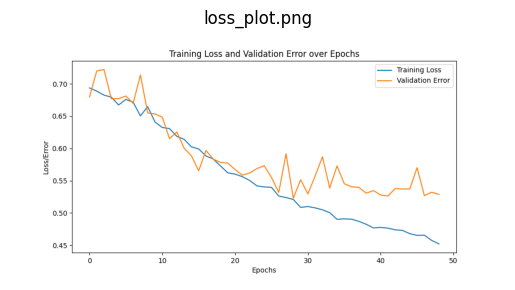

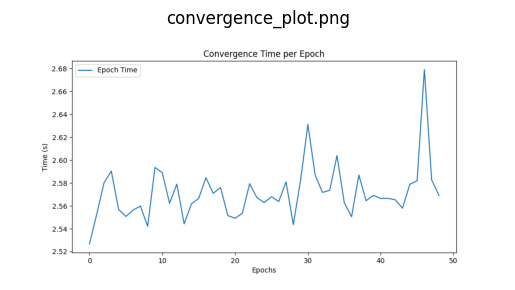

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# returns top experiments for printing their results
def get_top_experiments_for_printing(base_directory, top_n=10):
    accuracy_records = {}

    for subdir in os.listdir(base_directory):
        results_path = os.path.join(base_directory, subdir, 'results.csv')
        if os.path.exists(results_path):
            try:
                results_df = pd.read_csv(results_path)
                max_test_accuracy = results_df['Test Accuracy'].dropna().max()
                num_epochs = len(results_df)-1
                accuracy_records[subdir] = (max_test_accuracy, results_df, num_epochs)
            except Exception as e:
                print(f"Error reading {results_path}: {e}")

    # Sort directories by test accuracy
    sorted_records = sorted(accuracy_records.items(), key=lambda x: x[1][0], reverse=True)

    # Return top N directories with DataFrame
    return sorted_records[:top_n]

# display results of top experiments
def display_results(top_experiments, base_directory):
    for experiment, (accuracy, df, num_epochs) in top_experiments:
        subdir = os.path.join(base_directory, experiment)
        print(f"Subdirectory: {experiment}")
        print(f"Test Accuracy: {accuracy}")
        print(f"Number of Epochs: {num_epochs}")
        try:
            last_row = df.iloc[-1]
            print(f"Train Accuracy: {last_row['Train Accuracy']}")
            print(f"Validation Accuracy: {last_row['Validation Accuracy']}")
            total_convergence_time = df['Convergence Time'].sum()
            print(f"Total Convergence Time: {total_convergence_time} seconds")
        except Exception as e:
            print(f"Error processing accuracies and convergence time: {e}")

        plot_files = ['loss_plot.png', 'convergence_plot.png']
        for plot_file in plot_files:
            plot_path = os.path.join(subdir, plot_file)
            if os.path.exists(plot_path):
                img = plt.imread(plot_path)
                plt.imshow(img)
                plt.title(plot_file)
                plt.axis('off')
                plt.show()
            else:
                print(f"Plot not found: {plot_path}")

father_experiment_dir = 'best_results'
top_experiments = get_top_experiments_for_printing(father_experiment_dir)

display_results(top_experiments, father_experiment_dir)


In [ ]:
#loading the best model
model_path = "/sise/home/kirmayer/deep_learning/best_results/0.01_0.01_0.95_True_False_16/best_model.pt"
model = SiameseNetwork(True, False, 0.5).cuda()
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

Model Accuracy: 0.809


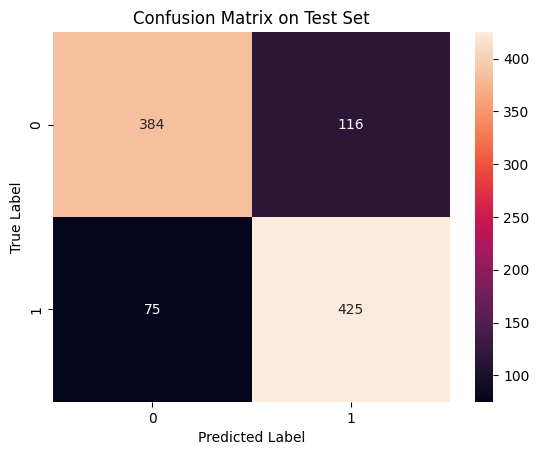

In [ ]:
torch.manual_seed(seed)

all_preds = []
all_labels = []
all_probs = []
batch_size = 16

test_dataset = ImageLoader(test, 'test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for images1, images2, labels in test_loader:
        outputs = model(images1.to(device), images2.to(device))
        predicted = outputs > 0.5
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
cm = confusion_matrix(all_labels, all_preds)
accuracy = np.trace(cm) / np.sum(cm).astype('float')

print(f'Model Accuracy: {accuracy:.3f}')

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Find indices of TP, TN, FP, and FN
tp_index = None
tn_index = None
fp_index = None
fn_index = None

for i in range(len(all_preds)):
    if all_labels[i] == 1.0 and all_probs[i] > 0.5:
        tp_index = i
    elif all_labels[i] == 0.0 and all_probs[i] < 0.5 :
        tn_index = i
    elif all_labels[i] == 1.0 and all_probs[i] < 0.5:
        fn_index = i
    elif all_labels[i] == 0.0 and  all_probs[i] > 0.5:
        fp_index = i

The probability is: 0.5430606




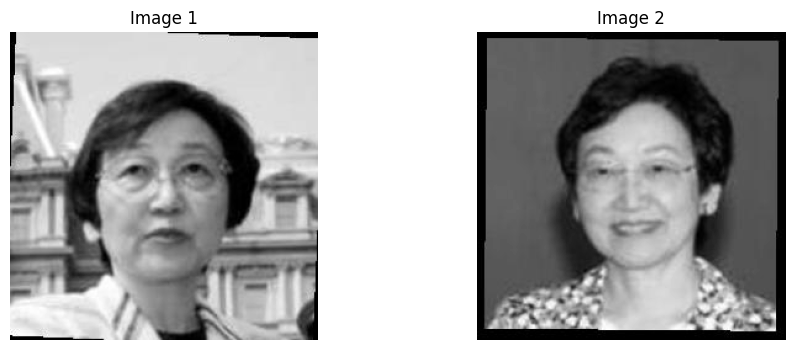

The probability is: 0.44247624




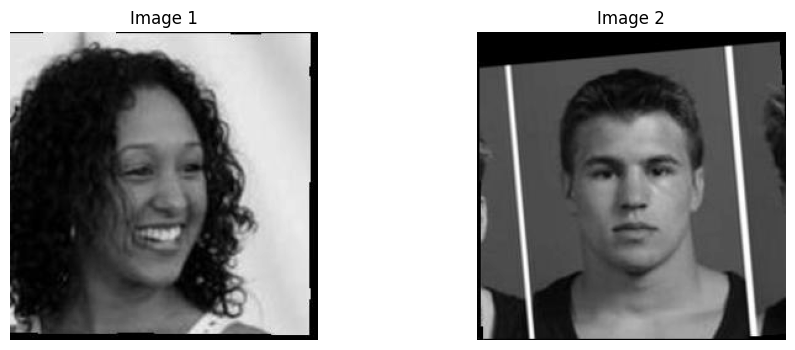

The probability is: 0.509154




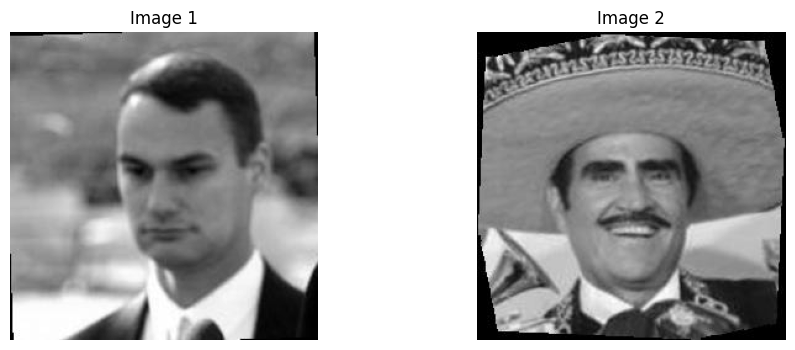

The probability is: 0.27923208




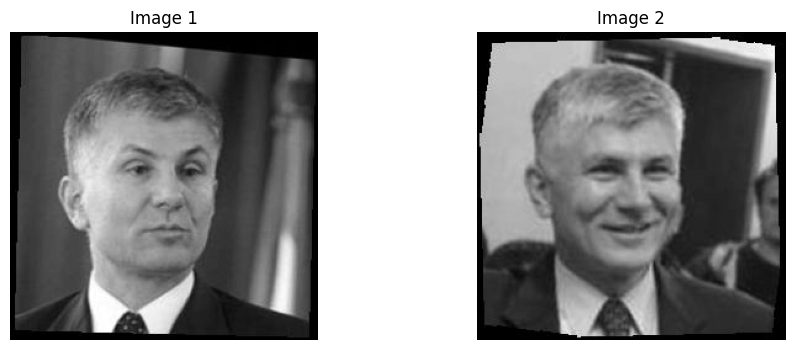

In [ ]:
def plot_images(sample, proba):
    if len(sample) == 3:
        name, p_num1, p_num2 = sample
        if int(p_num1) <= 9:
            image_path = f"./lfwa/lfw2/lfw2/{name}/{name}_000{p_num1}.jpg"
        else:
            image_path = f"./lfwa/lfw2/lfw2/{name}/{name}_00{p_num1}.jpg"

        if int(p_num2) <= 9:
            image_path2 = f"./lfwa/lfw2/lfw2/{name}/{name}_000{p_num2}.jpg"
        else:
           image_path2 = f"./lfwa/lfw2/lfw2/{name}/{name}_00{p_num2}.jpg"
    else: # len is 4
        name, p_num1, name2,  p_num2 = sample
        if int(p_num1) <= 9:
            image_path = f"./lfwa/lfw2/lfw2/{name}/{name}_000{p_num1}.jpg"
        else:
            image_path = f"./lfwa/lfw2/lfw2/{name}/{name}_00{p_num1}.jpg"

        if int(p_num2) <= 9:
            image_path2 = f"./lfwa/lfw2/lfw2/{name2}/{name2}_000{p_num2}.jpg"
        else:
            image_path2 = f"./lfwa/lfw2/lfw2/{name2}/{name2}_00{p_num2}.jpg"

    im = Image.open(image_path)
    im2 = Image.open(image_path2)
    print("The probability is:",proba[0])
    print("\n")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im, cmap='gray')
    plt.title("Image 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(im2, cmap='gray')
    plt.title("Image 2")
    plt.axis('off')

    plt.subplots_adjust(wspace=0.01)
    plt.show()

plot_images(test[tp_index], all_probs[tp_index])
plot_images(test[tn_index], all_probs[tn_index])
plot_images(test[fp_index], all_probs[fp_index])
plot_images(test[fn_index], all_probs[fn_index])